In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [2]:
data = load_iris()
X, y, column_names = data['data'], data['target'], data['feature_names']
X = pd.DataFrame(X, columns=column_names)
X['target'] = y

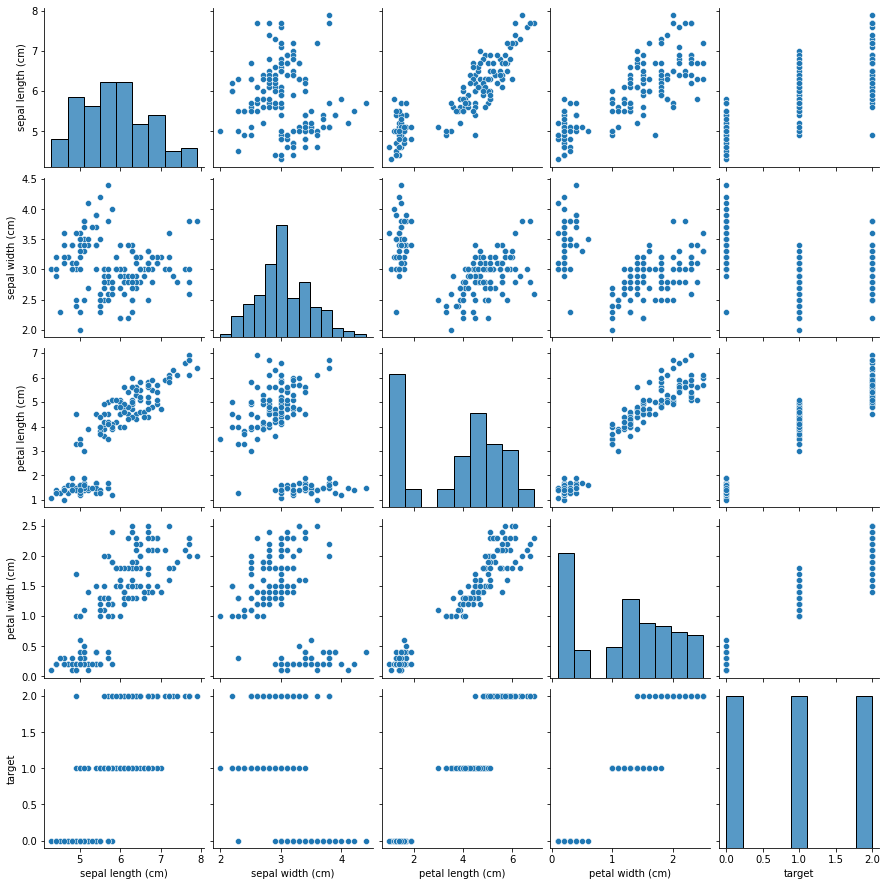

In [3]:
sns.pairplot(X)

In [4]:
X, y = X.drop(columns='target'), X['target']
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=8)

In [5]:
max_depth = 20
min_leaf_size = 3
max_nodes = 1000
classes = np.unique(y_train)

In [6]:
class Node:
    def __init__(self, right=None, left=None, column=None, threshold=None, probas=None, info_gain=None):
        self.right = right
        self.left = left
        
        self.column = column
        self.threshold = threshold
        
        self.probas = probas
        self.info_gain=info_gain

In [7]:
def crossentropy_loss(p_hat) -> float:
    total_sum = 0
    for p in p_hat:
        total_sum += p*np.log2(p)
    return total_sum

In [8]:
def gini(p_hat) -> float:
    total_sum = 0
    for p in p_hat:
        total_sum += p*(1-p)
    return total_sum

In [9]:
def calc_p_hat(values):
    p_hat = []
    for c in classes:
        p_hat.append(len(values[y_train==c])/len(values))
    return np.array(p_hat)

In [10]:
criterion = crossentropy_loss

In [11]:
def calc_loss(values, threshold):
    l_values, r_values = values[values<threshold], values[values>threshold]
    if len(l_values) == 0 or len(r_values) == 0:
        return 1000
    
    l_node = criterion(calc_p_hat(l_values))
    r_node = criterion(calc_p_hat(r_values))
    return (l_node*len(l_values)) + (r_node*len(r_values))

In [12]:
def find_best_split(parent_loss, column_names):
    node = (0, 'init', 0, 0)
    for name in column_names:
        for value in X_train[name]:
            threshold = value
            current_loss = parent_loss - calc_loss(X_train[name], threshold)
            if current_loss > node[0]:
                node = (
                    current_loss, name, threshold, criterion(calc_p_hat(X_train[name]))
                )
    return node
    

In [13]:
def build_node(values, column_names):
    parent_loss = criterion(calc_p_hat(values))
    node = find_best_split(parent_loss, column_names)
    if node[1] == 'init':
        return
    
    return Node(column=node[1], threshold=node[2], probas=node[3], info_gain=node[0])

In [14]:
def build_decision_tree(values, column_names, nodes, depth):
    if len(column_names) == 0 or len(values) == 0:
        return
    
    if nodes == max_nodes or depth == max_depth:
        return
    
    node = build_node(values, column_names)
    if node == None:
        return
    
    nodes+=1
    column_names.remove(node.column)
    
    depth+=1
    node.left = build_decision_tree(values[values<node.threshold], deepcopy(column_names), nodes, depth)
    node.right = build_decision_tree(values[values>node.threshold], deepcopy(column_names), nodes, depth)
    depth-=1
    
    return node

In [15]:
decision_tree = build_decision_tree(X_train, column_names, 0, 0)

/var/folders/6p/xphl3__n27xg2byxtbd0slhc0000gq/T/ipykernel_5286/3227384227.py:4: RuntimeWarning: divide by zero encountered in log2
  total_sum += p*np.log2(p)
/var/folders/6p/xphl3__n27xg2byxtbd0slhc0000gq/T/ipykernel_5286/3227384227.py:4: RuntimeWarning: invalid value encountered in double_scalars
  total_sum += p*np.log2(p)


In [16]:
print(f'Split in {decision_tree.column} (threshold {decision_tree.threshold}) with info gain: {decision_tree.info_gain}. On the left goes {decision_tree.left.column} and on the right {decision_tree.right.column}')

Split in sepal width (cm) (threshold 2.6) with info gain: 159.00017648372344. On the left goes sepal length (cm) and on the right sepal length (cm)


In [17]:
decision_tree_l1 = decision_tree.left
print(f'Split in {decision_tree_l1.column} with info gain: {decision_tree_l1.info_gain}.')

Split in sepal length (cm) with info gain: 104.66230741296869.


In [18]:
decision_tree_r1 = decision_tree.right
print(f'Split in {decision_tree_r1.column} with info gain: {decision_tree_r1.info_gain}.')

Split in sepal length (cm) with info gain: 104.66230741296869.
